## Error analysis

Some studies on neural network results

In [1]:
from bs4 import BeautifulSoup
import urllib
import pdb
import json
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.data_utils import get_file
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Merge, Dropout, RepeatVector
from keras.layers import recurrent
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, Callback

from utils import create_vectors_dataset, get_spacy_vectors
import h5py
import theano.tensor as T
from spacy.en import English
from itertools import izip_longest


%matplotlib inline

Using Theano backend.
Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 4007)


In [43]:
training_set_file = 'data/training_set.dat'
test_set_file = 'data/test_set.dat'

train_facts = pickle.load(open(training_set_file,'r'))

test_facts = pickle.load(open(test_set_file,'r'))

train_stories = [(reduce(lambda x,y: x + y, map(list,fact)),q) for fact,q in train_facts]
test_stories = [(reduce(lambda x,y: x + y, map(list,fact)),q) for fact,q in test_facts]


vocab = sorted(reduce(lambda x, y: x | y, (set(story + [answer]) for story, answer in train_stories + test_stories)))
story_vocab = sorted(reduce(lambda x, y: x | y, (set(story) for story, answer in train_stories + test_stories)))

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _ in train_stories + test_stories)))


print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

answer_vocab = sorted(reduce(lambda x, y: x | y, (set([answer]) for _, answer in train_stories + test_stories)))
# Reserve 0 for masking via pad_sequences
answer_dict = dict((word, i) for i, word in enumerate(answer_vocab))
print('Answers dict len: {0}'.format(len(answer_dict)))


-
('Vocab size:', 21520, 'unique words')
('Story max length:', 1647, 'words')
('Number of training stories:', 133093)
('Number of test stories:', 59394)
-
Here's what a "story" tuple looks like (input, query, answer):
([u'barrett', u'esophagus', u'itself', u'does', u'not', u'cause', u'symptoms', u'.', u'many', u'people', u'with', u'this', u'condition', u'do', u'not', u'have', u'any', u'symptoms', u'.', u'the', u'acid', u'reflux', u'that', u'causes', u'barrett', u'esophagus', u'often', u'leads', u'to', u'symptoms', u'of', u'heartburn', u'.'], u'barrett esophagus')
-
Vectorizing the word sequences...
Answers dict len: 2350


### Training curves

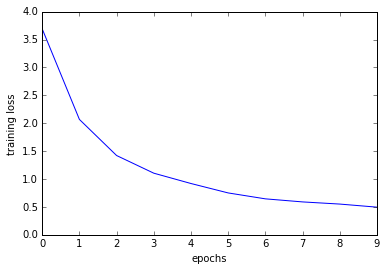

In [18]:
results = np.loadtxt('logs/log_GRU_128_drop_0.5.txt')
X = range(results.shape[0])
plt.plot(X,results[:,0])
plt.ylabel('training loss')
plt.xlabel('epochs')

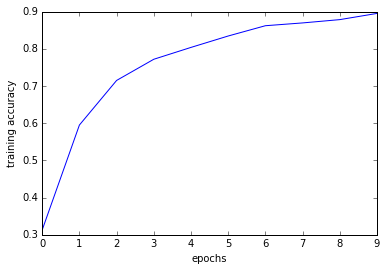

In [19]:
X = range(results.shape[0])
plt.plot(X,results[:,1])
plt.ylabel('training accuracy')
plt.xlabel('epochs')

In [20]:
RNN = recurrent.LSTM
NUM_HIDDEN_UNITS = 128
BATCH_SIZE = 32
EPOCHS = 40
DROPOUT_FACTOR = 0.5
print('RNN / HIDDENS = {}, {}'.format(RNN, NUM_HIDDEN_UNITS))

vocab_size = 2350
max_len = 500
word_vec_dim = 300

model = Sequential()
model.add(GRU(output_dim = NUM_HIDDEN_UNITS, activation='tanh', 
               return_sequences=True, input_shape=(max_len, word_vec_dim)))
model.add(Dropout(DROPOUT_FACTOR))
model.add(GRU(NUM_HIDDEN_UNITS, return_sequences=False))
model.add(Dense(vocab_size, init='uniform',activation='softmax'))

print('Compiling model...')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Compilation done...')
model.load_weights('models/weights_GRU_{0}_drop_0.5.hdf5'.format(NUM_HIDDEN_UNITS))


RNN / HIDDENS = <class 'keras.layers.recurrent.LSTM'>, 128
Compiling model...
Compilation done...


In [21]:
import random
random.seed(1337)
# Pickle to avoid reload
n_test = len(test_stories)
# Reserve 0 for masking via pad_sequences

nlp = English()


### Relationship between large of stories and error?

(59394,)
59394


(0, 120)

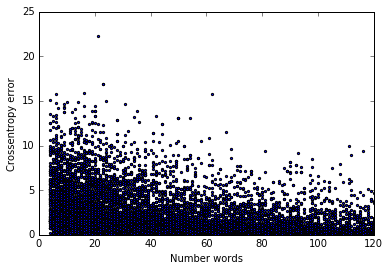

In [27]:

all_err = np.loadtxt('logs/error.dat')
stories_len = map(len, (x for x, _ in test_stories))

print all_err.shape
print len(test_stories)

plt.scatter(stories_len, all_err, alpha=1., s=5.)
plt.xlabel('Number words')
plt.ylabel('Crossentropy error')
plt.ylim([0,25])
plt.xlim([0,120])

#print all_err


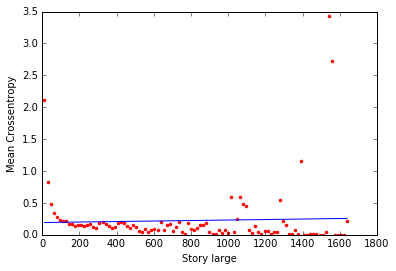

In [28]:

n_bins = 100
n,vals = np.histogram(stories_len, bins=n_bins)
e = (vals[:-1] + vals[1:]) / 2
# Avoiding values with more than 60 -> avoid high var
#max_ind = np.argmax(e > 60)
max_ind = e.shape[0]
sy,_ = np.histogram(stories_len, bins=n_bins, weights=all_err)
sy2, _ = np.histogram(stories_len, bins=n_bins, weights=all_err*all_err)
mean = sy / n
std = np.sqrt(sy2/n - mean*mean)

mean[np.isnan(mean)] = 0

#plt.errorbar(e[:max_ind],mean[:max_ind],yerr=std[:max_ind])
plt.plot(e[:max_ind],mean[:max_ind],'r.')
m, b = np.polyfit(e[:max_ind], mean[:max_ind], 1)
plt.plot(e, m*e + b,'-')

plt.xlabel('Story large')
plt.ylabel('Mean Crossentropy')


Some relation but not so clear

### Visualizing neuron activations

In [29]:
from keras import backend as K

# Compute activations from first layer for example and n_words
get_1_layer_output = K.function([model.layers[0].input,K.learning_phase()],
                               [model.layers[1].output])

In [63]:
n_test = 50
nlp = English()
rec_test_stories = test_stories[9922:9922+n_test]
rec_test_facts = test_facts[9922:9922+n_test]
inputs_test, answers_test = get_spacy_vectors(rec_test_stories, answer_dict, max_len, nlp)

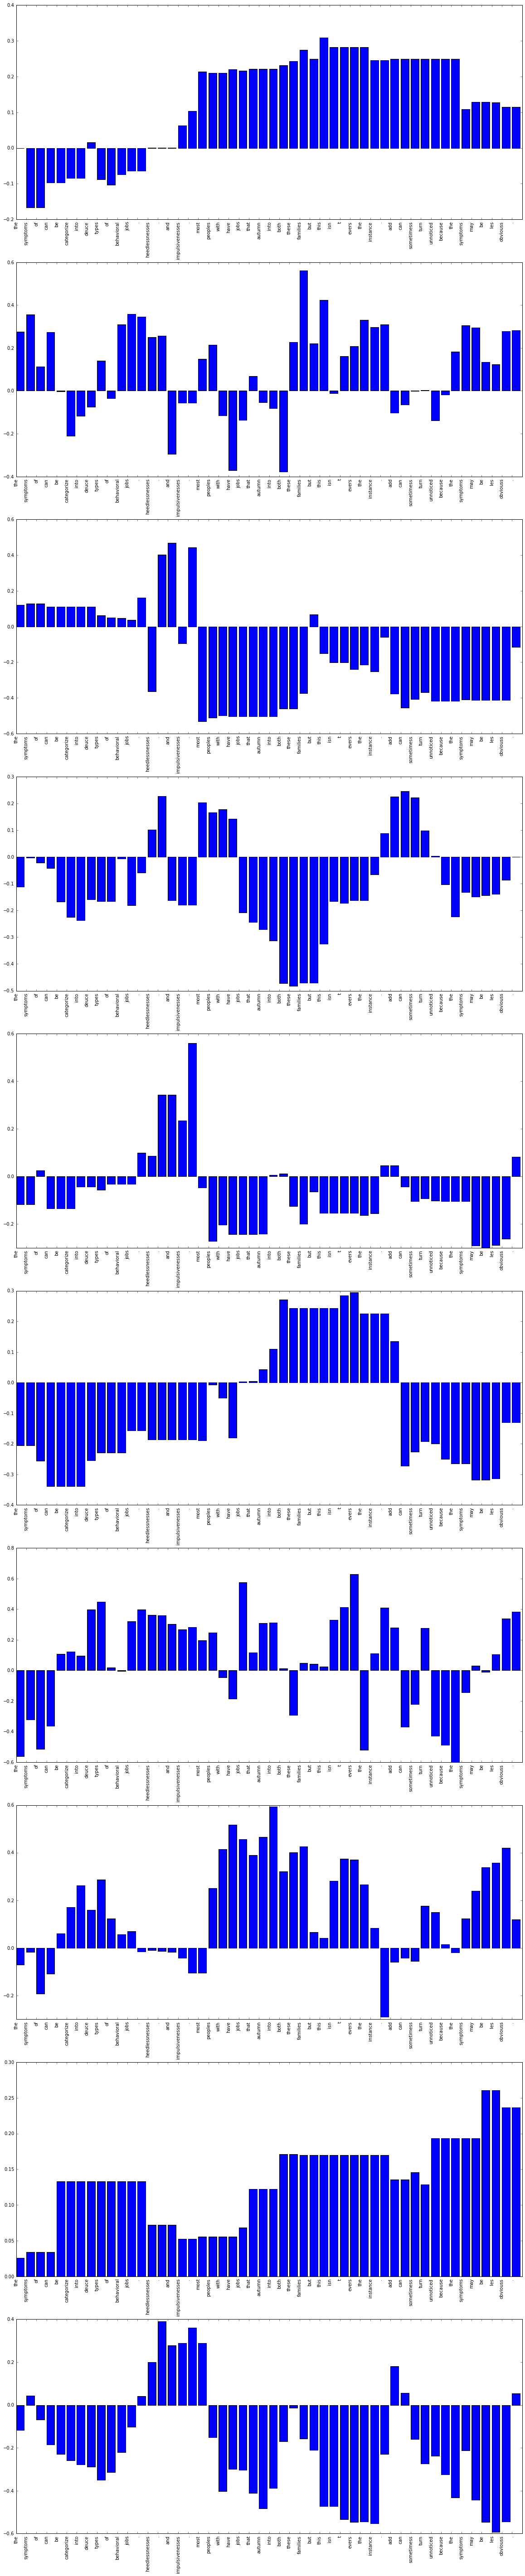

In [64]:
# Activations from layer 1
n_words = 50
example = 0

layer_output = get_1_layer_output([inputs_test[example:example+1],0])[0]
# Compute tanh of activations of a random cell to keep it in -1 - 1
#activation = layer_output.sum(axis=2)
#activation = np.tanh(activation)
activation = np.tanh(layer_output[:,:,:])
# Only considering non zero activation
activation = activation[0,-len(rec_test_stories[example][0]):,:]
#activation_word = zip(test_stories[example][0:n_words],activation.flatten()[0:n_word])
f, ax = plt.subplots(10,figsize=(20,100))
start = 21

for n in range(start,start+10):
    ax[n-start].bar(range(len(rec_test_stories[example][0][0:n_words])),activation[:,n].flatten()[0:n_words])
    ax[n-start].set_xticks(range(len(rec_test_stories[example][0][0:n_words])))
    _ = ax[n-start].set_xticklabels(rec_test_stories[example][0][0:n_words],rotation='vertical')



### Predictions on dataset 

In [66]:
print_n = 50

choose = np.random.choice(inputs_test.shape[0],print_n,replace=False)

predictions = model.predict(inputs_test[choose])

for k,pred in enumerate(predictions):
    prediction = np.argsort(pred)[-5:][::-1]
    pred_words = [answer_dict.keys()[answer_dict.values().index(pred)] for pred in prediction]
    print('Prediction for data:')
    #print(rec_test_facts[choose[k]][0])
    print('Disease: {0}'.format(rec_test_stories[choose[k]][1]))
    print('5 most prob. diseases: {0}'.format(pred_words))

Prediction for data:
Disease: atrial fibrillation or flutter
5 most prob. diseases: [u'separation anxiety in children', u'aortic insufficiency', u'ventricular tachycardia', u'pulmonary edema', u'pulmonary embolus']
Prediction for data:
Disease: attention deficit hyperactivity disorder
5 most prob. diseases: [u'attention deficit hyperactivity disorder', u'persistent depressive disorder', u'oppositional defiant disorder', u'failure to thrive', u'seasonal affective disorder']
Prediction for data:
Disease: atrial fibrillation or flutter
5 most prob. diseases: [u'atrial fibrillation or flutter', u'ventricular tachycardia', u'pulmonary embolus', u'arrhythmias', u'unconsciousness first aid']
Prediction for data:
Disease: attention deficit hyperactivity disorder
5 most prob. diseases: [u'attention deficit hyperactivity disorder', u'neuromyotonia', u'systemic lupus erythematosus', u'menopause', u'fibromyalgia']
Prediction for data:
Disease: athlete s foot
5 most prob. diseases: [u'athlete s foo

### Trying predictions on self-made symptoms

In [34]:
facts = [[
    #'acne'
    u'oily skin',
    u'painful touch skin',
    u'face affected almost everywhere',
    u'chest affected',
    u'some blackheads',
    u'a lot of papules',
    u'papules',
    u'nodules',
    u'cysts'
    ],
    #'abdominal aortic aneurysm'
    [u'pulsating feeling in stomach',
    u'persistent back pain',
    u'abdominal pain',
    u'severe pain in the middle abdomen',
    u'dizziness',
    u'clammy skin',
    u'tachycardia',
    u'loss of consciousness'],
    #'brain abscess'
    [u'symptoms for two weeks',
     u'headache severe, cannot be relieved by painkillers',
     u'confusion and irritability',
     u'fever',
     u'seizures',
     u'vomiting and nausea',
     u'changes in vision',
     u'muscle weakness'    
    ],
    #'brain abscess'
    # This case is discovered only using the second fact ... which is very bad ... is not identifying the important first 
    # fact at all .. maybe we should invert the order of all the facts?
    # It gives a 'LOT OF IMPORTANCE TO LAST FACTS'
    [u'modifications in vision such as blur grey of vision or double vision due to the putting pressure on the eye nerve',
     u'if you or person you know experiences any of these symptoms phone 999 now and ask for an ambulance'],
    #'acid reflux',
    [u'uncomfortable burning sensation in the chest',
     u'felt below your breastbone',
     u'worse after eating',
     u'pain when bending over or lying down',
     u'stomach contents are brought back up into throat and mouth',
     u'stomach acid irritating your airway',
     u'tooth decay',
     u'a persistent cough or wheezing',
     u'sore throat',
     u'pain when swallowing'
    ],
    # 'alcohol-related liver disease'
    [u'confusion and memory problems',
     u'vomiting blood and black',
     u'a tendency to bleed more easily such as frequent bleeding gums',
     u'increased sensitivity to alcohol and drugs',
     u'Have you ever felt guilty about your drinking',
     u'if you answer yes to one or more of the questions you may have an alcohol problem',
     u'see your gp as soon as possible if you have symptoms of advanced arld'
    ],
    #'agoraphobia'
    [
     u'unable to leave the house',
     u'anxiety',
     u'the physical symptoms of agoraphobia can be similar to those of a panic attack',
     u'rapid heartbeat',
     u'feeling hot and sweaty',
     u'rapid breathing',
     u'difficulty swallowing',
     u'diarrhoea',
     u'dizziness',
     u'feeling faint',
     u'avoiding being far away from home',
     u'thoughts of suicide or self-harm'
    ],
    # 'ais'
    [u'girls will not have a womb or ovaries and will be unable to get pregnant',
     u'hypospadias where the hole that carries urine out of the body is on the underside of the penis rather than at the end',
     u'partially undescended testicles',
     u'a very small penis or an enlarged clitoris',
     u'develop breasts and have growth spurts as normal, although she may end up slightly taller than usual for a girl',
     u'develop little or no pubic and underarm hair'
    ],
    #'atrial fibrillation'
    [u'chest pain',
     u'feeling faint or lightheaded',
     u'breathlessness',
     u'tiredness and being less able to exercise',
     u'as well as an irregular heartbeat your heart may also beat very fast',
     u'heart palpitations',
     u'tiredness and feeling lethargic to ageing',
     u'you should see your gp immediately if you notice a sudden change in your heartbeat and experience chest pain'      
    ],
    #'adhd'
    [u'problems such as difficulties with relationships, social interaction, drugs and crime',
     u'hard to find and stay in a job',
     u'obsessive compulsive disorder a condition that causes obsessive thoughts and compulsive behaviour',
     u'bipolar disorder',
     u'conditions in which an individual differs significantly from an average person in terms of how they think, perceive feel or relate to others',
     u'extreme impatience',
     u'taking risks in activities',
     u'inability to deal with stress',
     u'difficulty keeping quiet and speaking out of turn',
     u'forgetfulness',
     u'poor organisational skills',
     u'inability to focus or prioritise',
     u'poor organisational skills',
     u'little or no sense of danger'
    ]
    ]
diseases = ['acne','abdominal aortic aneurysm','brain abscess','brain abscess','acid reflux',
            'alcohol-related liver disease','agoraphobia','ais','atrial fibrillation','adhd']

In [35]:
print('Get word vectors for input')
for k,fact in enumerate(facts):
    facts_list = fact

    facts_list = [fact.split(' ') + ['.'] for fact in facts_list]
    facts_list = [facts_list]
    x = [reduce(lambda x,y: x + y, map(list,fact)) for fact in facts_list]

    #x_vectors = inputs_test[0].reshape(1,inputs_test[0].shape[0],inputs_test[1].shape[1])
    x_vectors = get_spacy_vectors([[x[0],None]], None, max_len, nlp)

    pred = model.predict(x_vectors[0])

    prediction = np.argsort(pred[0])[-5:][::-1]
    pred_words = [answer_dict.keys()[answer_dict.values().index(pred)] for pred in prediction]
    print('Prediction for data:')
    #print(x[0])
    print('Disease: {0}'.format(diseases[k]))
    print('5 most prob. diseases: {0}'.format(pred_words))

Get word vectors for input
Prediction for data:
Disease: acne
5 most prob. diseases: [u'acne', u'genital warts', u'scarlet fever', u'erythema multiforme', u'measles']
Prediction for data:
Disease: abdominal aortic aneurysm
5 most prob. diseases: [u'pulmonary actinomycosis', u'mucormycosis', u'sleeping sickness', u'acute myeloid leukemia', u'bile duct obstruction']
Prediction for data:
Disease: brain abscess
5 most prob. diseases: [u'serotonin syndrome', u'alcoholic ketoacidosis', u'brain abscess', u'barbiturate intoxication and overdose', u'propane poisoning']
Prediction for data:
Disease: brain abscess
5 most prob. diseases: [u'brain abscess', u'conversion disorder', u'labyrinthine fistula', u'malignant brain tumour cancerous', u'coats disease']
Prediction for data:
Disease: acid reflux
5 most prob. diseases: [u'gastroesophageal reflux disease', u'dysphagia swallowing problems', u'pulmonary embolus', u'fire ants', u'thrombophilia']
Prediction for data:
Disease: alcohol-related liver d

In [15]:
# Save results ordered by how much the network was wrong
# Ordering error from bigger to smaller

order_err = np.argsort(all_err)[::-1]
predictions = model.predict(inputs_test)
most_prob = []

for k,pred in enumerate(predictions):
    prediction = np.argsort(pred)[-5:][::-1]
    pred_words = [answer_dict.keys()[answer_dict.values().index(pred)] for pred in prediction]
    most_prob.append(pred_words)


In [36]:
# Writing to file
output_file = 'logs/output_ordered.txt'
with open(output_file,'w') as fil:
    for k,indx in enumerate(order_err):
        facts = test_facts[indx]
        for fact in facts[0]:
            fil.write(u' '.join(fact).encode('utf-8') + '\n')
        fil.write('Disease: ' + facts[1].encode('utf-8') + '\n')
        fil.write('5 More prob.: ' + str(most_prob[indx]) + '\n\n')